In [274]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from scipy.optimize import curve_fit
import matplotlib as mpl
import struct
import glob
import os 
import struct
from sklearn import linear_model
import scipy.linalg
from scipy import stats
from scipy import integrate
hubble = 0.73
vmax_MW = 220.0
vmax_M31 = 270.0
m_star_M31 = 10.3
m_star_MW = 6.08

%matplotlib inline

In [189]:
def load_summary(filename):
    dtype=[('minr', 'f8'),
           ('maxr', 'f8'), 
           ('ca_ratio', 'f8'),
           ('ba_ratio', 'f8'),
           ('a', 'f8'),
           ('center', 'f8'),
           ('width', 'f8'),
           ('mu', 'f8')]
    summary = np.loadtxt(filename, dtype=dtype)    
    return summary

In [2]:
def load_snapshot(snap_name, boxsize=75000.0):
    dtype=[('subid','i8'),
           ('parentid','i8'),
           ('x', 'f8'),
           ('y', 'f8'), 
           ('z', 'f8'),
           ('vx', 'f8'),
           ('vy', 'f8'),
           ('vz', 'f8'),
           ('vmax', 'f8'),
           ('bmag', 'f8'),
           ('vmag', 'f8'),
           ('mstar', 'f8')]
    snap_data = np.loadtxt(snap_name, dtype=dtype)    
    # this takes into account periodic boudary conditions from Illustris
    for col in list(['x','y','z']):
        if((snap_data[col].max() - snap_data[col].min()) > 0.5 * boxsize):
            snap_data[col] = (snap_data[col] - 0.5 * boxsize) % boxsize
    return snap_data

In [3]:
def load_obs(obs_name):
    dtype=[('name','|S20'),
           ('x', 'f8'),
           ('y', 'f8'), 
           ('z', 'f8'),
           ('delta_plus', 'f8'),
           ('delta_minus', 'f8'),
           ('vmag', 'f8'),
           ('delta_vmag', 'f8')]
    obs_data = np.loadtxt(obs_name, dtype=dtype)    
    return obs_data

In [4]:
def main_halos(snap_data, sort_column='mstar', single_reverse=False):
    id_sorted = np.argsort(snap_data[sort_column])
    if single_reverse:
        id_halo_A = id_sorted[0]
        main_halos_data = snap_data[id_halo_A]
    else:
        id_halo_A = id_sorted[-1]
        id_halo_B = id_sorted[-2]
        main_halos_data = snap_data[[id_halo_A, id_halo_B]]
    return main_halos_data

In [75]:
def satellite_halos(halo_data, halo_center, vmax=None, max_points=10, sort_column='vmag'):
    jj = np.argsort(halo_data[sort_column])
    tmp_halo = halo_data[jj]
    if vmax is None:
        radius = halo_center['vmax']/(10.0 * 100 * hubble) * 1000 # in kpc
    else:
        radius = vmax/(10.0 * 100 * hubble) * 1000  # in kpc
    radius = 300
    print('radius', radius)
    for col in list(['x','y','z']):
        tmp_halo[col] = tmp_halo[col] - halo_center[col]
    
    r = np.sqrt(tmp_halo['x']**2 + tmp_halo['y']**2 + tmp_halo['z']**2)
    ii = (r < radius) & (r>1E-6)
    
    tmp_halo = tmp_halo[ii]
    r = np.sqrt(tmp_halo['x']**2 + tmp_halo['y']**2 + tmp_halo['z']**2)
    #print(tmp_halo[:max_points],r[:max_points])
    return tmp_halo[:max_points], np.min(r[:max_points]), np.max(r[:max_points])

In [76]:
def spherical_randomize(x_in, y_in, z_in):
    """
    Randomizes a set of points around the coordinates origin.
    """
    n_points = len(x_in)
    r = np.sqrt(x_in**2 + y_in**2 + z_in**2)
    phi = np.random.random(n_points) * 2.0 * np.pi
    costheta = 2.0*(np.random.random(n_points) -0.5)
    theta = np.arccos(costheta)
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

In [77]:
def inertiaTensor(x_in,y_in,z_in, randomize=False):
    # first recenter the data
    x = x_in - np.mean(x_in)
    y = y_in - np.mean(y_in)
    z = z_in - np.mean(z_in)
    if randomize:
        x, y, z = spherical_randomize(x_in - np.mean(x_in), 
                                      y_in - np.mean(y_in), 
                                      z_in - np.mean(z_in))
    
    I=[]
    for index in range(9):
        I.append(0)
   
    I[0] = np.sum(y*y+z*z) 
    I[1] = np.sum(-y*x)    
    I[2] = np.sum(-x*z)    
    I[3] = np.sum(-y*x)    
    I[4] = np.sum(x*x+z*z) 
    I[5] = np.sum(-y*z)    
    I[6] = np.sum(-z*x)    
    I[7] = np.sum(-z*y)    
    I[8] = np.sum(x*x+y*y) 
    tensor = np.array([(I[0:3]), (I[3:6]), (I[6:9])])
    vals, vects = np.linalg.eig(tensor)  # they come out unsorted, so the command below is needed
    eig_ord = np.argsort(vals)  # a thing to note is that here COLUMN i corrensponds to eigenvalue i.
    ord_vals = vals[eig_ord]
    ord_vects = vects[:, eig_ord].T
    
    plane_vector = ord_vects[2]
    distance_to_plane = x * plane_vector[0]
    distance_to_plane += y * plane_vector[1]
    distance_to_plane += z * plane_vector[2]

    #use ord_vects[2] to define the plane width
    return ord_vals, plane_vector, distance_to_plane.mean(), distance_to_plane.std()

In [78]:
def gen_random_sphere(n_points):
    """
    Sets of points in the 3D sphere
    """
    r = np.random.random(n_points)**(1.0/3.0)
    phi = np.random.random(n_points) * 2.0 * np.pi
    costheta = 2.0*(np.random.random(n_points) -0.5)
    theta = np.arccos(costheta)
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

In [79]:
def sample_plane_width(x_in, y_in, z_in , n_realizations=100):
    """
    Sample the best plane width for  different n_points
    """

    p_width_all = np.zeros(n_realizations)
    p_center_all = np.zeros(n_realizations)
    for i in range(n_realizations):
        x, y, z = spherical_randomize(x_in, y_in, z_in)
        pos = np.array([x,y,z])
        p_width_all[i], p_center_all[i] , q = get_best_plane(pos)
    
    return p_width_all.mean(), p_width_all.std(), p_center_all.mean(), p_center_all.std()

In [182]:
def write_inertia_plane(output_stream, satellite_data, center_data, unit_vector=[0,0,1], randomize=False):
    # inertia tensor
    x_pos = satellite_data['x'] 
    y_pos = satellite_data['y'] 
    z_pos = satellite_data['z'] 

    values, vec_a, center, width = inertiaTensor(x_pos, y_pos, z_pos, randomize=randomize)
    
    output_stream.write("{:.2e}  {:.2e}  {:.2e}\t".format(np.sqrt(values[0])/np.sqrt(values[2]), 
                                                          np.sqrt(values[1])/np.sqrt(values[2]), 
                                                          np.sqrt(values[2])))
    mu_I = 0
    for i in range(3):
        mu_I += vec_a[i]* unit_vector[i]
        
    output_stream.write("{:.4f} {:.4f} {:.4f}\t".format(center, width, np.abs(mu_I)))
    return
    

def write_center_info(output_stream, center_A, center_B):
    #distance between halos in kpc/h and vector connecting the two halos
    r_AB = np.ones(3)
    r_AB[0] = center_A['x'] - center_B['x']
    r_AB[1] = center_A['y'] - center_B['y']
    r_AB[2] = center_A['z'] - center_B['z']
    d_AB =  np.sqrt(np.sum(r_AB**2))
    r_AB = r_AB/d_AB
    return r_AB

In [183]:
def make_LG_stats(n_sat_max=3, n_random=1000, data_path = "../data/mstar_selected/", output_path = "../data/obs_summary/"):
    MW_data = load_obs("../data/obs/MW_satellites.txt")
    M31_data = load_obs("../data/obs/M31_satellites.txt")
    
    M31 = main_halos(M31_data, sort_column='vmag', single_reverse=True)
    MW = main_halos(MW_data, sort_column='vmag', single_reverse=True)
    
    satellite_data_A, min_r_M31, max_r_M31 = satellite_halos(M31_data, M31, vmax=vmax_M31, max_points=n_sat_max)
    satellite_data_B, min_r_MW, max_r_MW = satellite_halos(MW_data, MW, vmax=vmax_MW, max_points=n_sat_max)
 
    #number of bright satellites
    N_A = len(satellite_data_A)
    N_B = len(satellite_data_B)

    # bright satellites
    print('N bright:!', N_A, N_B)
    
    output_A = open(os.path.join(output_path, "halo_M31_nmax_{}.dat".format(n_sat_max)), "w")
    output_B = open(os.path.join(output_path, "halo_MW_nmax_{}.dat".format(n_sat_max)), "w")

    #minimum and maximum radius for the satellites
    output_A.write("{:2f} {:2f}\t".format(min_r_M31, max_r_M31))
    output_B.write("{:2f} {:2f}\t".format(min_r_MW, max_r_MW))

    r_AB = write_center_info(output_A, M31, MW)
    r_AB = write_center_info(output_B, M31, MW)
    write_inertia_plane(output_A, satellite_data_A, M31, unit_vector=r_AB, randomize=False)
    write_inertia_plane(output_B, satellite_data_B, MW, unit_vector=r_AB, randomize=False)
    output_A.write("\n")
    output_B.write("\n")
    
    for i in range(n_random):
        output_A.write("{:2f} {:2f}\t".format(min_r_M31, max_r_M31))
        output_B.write("{:2f} {:2f}\t".format(min_r_MW, max_r_MW))
        r_AB = write_center_info(output_A, M31, MW)
        r_AB = write_center_info(output_B, M31, MW)
        write_inertia_plane(output_A, satellite_data_A, M31, unit_vector=r_AB, randomize=True)
        write_inertia_plane(output_B, satellite_data_B, MW, unit_vector=r_AB, randomize=True)

        output_A.write("\n")
        output_B.write("\n")

    output_A.close()
    output_B.close()

In [184]:
def make_illustris_stats(group_id=0, n_sat_max=3, n_sat_min=15, n_random=1000, 
                         data_path = "../data/mstar_selected/", output_path = "../data/mstar_selected_summary/"):
    LG_data = load_snapshot(os.path.join(data_path, "Illustris_group_{}.dat".format(group_id)))
    M31, MW = main_halos(LG_data, sort_column='mstar', single_reverse=False)
    #print(M31)
    #print(MW)
   
    # check that we have at least n_sat_min satellites to choose from
    satellite_data_A, min_r_M31, max_r_M31 = satellite_halos(LG_data, M31, sort_column='vmax',
                                                             vmax=M31['vmax'], max_points=n_sat_min)
    satellite_data_B, min_r_MW, max_r_MW = satellite_halos(LG_data, MW, sort_column='vmax',
                                                           vmax=MW['vmax'], max_points=n_sat_min)
    N_A = len(satellite_data_A)
    N_B = len(satellite_data_B)

    if((N_A!=n_sat_min) | (N_B!=n_sat_min)):
        print('First check Groupid, N bright:!', group_id, N_A, N_B)
        return
    
    satellite_data_A, min_r_M31, max_r_M31 = satellite_halos(LG_data, M31, sort_column='vmax',
                                                             vmax=M31['vmax'], max_points=n_sat_max)
    satellite_data_B, min_r_MW, max_r_MW = satellite_halos(LG_data, MW, sort_column='vmax',
                                                           vmax=MW['vmax'], max_points=n_sat_max)
 
    #number of bright satellites
    N_A = len(satellite_data_A)
    N_B = len(satellite_data_B)

    # bright satellites
    print('Groupid, N bright:!', group_id, N_A, N_B)
    
    output_A = open(os.path.join(output_path, "Illustris_M31_group_{}_nmax_{}.dat".format(group_id, n_sat_max)), "w")
    output_B = open(os.path.join(output_path, "Illustris_MW_group_{}_nmax_{}.dat".format(group_id, n_sat_max)), "w")

    #minimum and maximum radius for the satellites
    output_A.write("{:2f} {:2f}\t".format(min_r_M31, max_r_M31))
    output_B.write("{:2f} {:2f}\t".format(min_r_MW, max_r_MW))

    r_AB = write_center_info(output_A, M31, MW)
    r_AB = write_center_info(output_B, M31, MW)
    write_inertia_plane(output_A, satellite_data_A, M31, unit_vector=r_AB, randomize=False)
    write_inertia_plane(output_B, satellite_data_B, MW, unit_vector=r_AB, randomize=False)
    output_A.write("\n")
    output_B.write("\n")
    
    for i in range(n_random):
        output_A.write("{:2f} {:2f}\t".format(min_r_M31, max_r_M31))
        output_B.write("{:2f} {:2f}\t".format(min_r_MW, max_r_MW))
        r_AB = write_center_info(output_A, M31, MW)
        r_AB = write_center_info(output_B, M31, MW)
        write_inertia_plane(output_A, satellite_data_A, M31, unit_vector=r_AB, randomize=True)
        write_inertia_plane(output_B, satellite_data_B, MW, unit_vector=r_AB, randomize=True)

        output_A.write("\n")
        output_B.write("\n")

    output_A.close()
    output_B.close()

In [200]:
for i in range(11,16):
    make_LG_stats(n_sat_max=i, n_random=10000)

radius 300
radius 300
N bright:! 11 11
radius 300
radius 300
N bright:! 12 12
radius 300
radius 300
N bright:! 13 13
radius 300
radius 300
N bright:! 14 14
radius 300
radius 300
N bright:! 15 15


In [186]:
for i in range(11,16):
    for j in range(27):
        make_illustris_stats(group_id=j, n_sat_max=i, n_random=1000)

radius 300
radius 300
radius 300
radius 300
Groupid, N bright:! 0 11 11
radius 300
radius 300
radius 300
radius 300
Groupid, N bright:! 1 11 11
radius 300
radius 300
radius 300
radius 300
Groupid, N bright:! 2 11 11
radius 300
radius 300
radius 300
radius 300
Groupid, N bright:! 3 11 11
radius 300
radius 300
radius 300
radius 300
Groupid, N bright:! 4 11 11
radius 300
radius 300
radius 300
radius 300
Groupid, N bright:! 5 11 11
radius 300
radius 300
radius 300
radius 300
Groupid, N bright:! 6 11 11
radius 300
radius 300
First check Groupid, N bright:! 7 15 14
radius 300
radius 300
radius 300
radius 300
Groupid, N bright:! 8 11 11
radius 300
radius 300
radius 300
radius 300
Groupid, N bright:! 9 11 11
radius 300
radius 300
radius 300
radius 300
Groupid, N bright:! 10 11 11
radius 300
radius 300
radius 300
radius 300
Groupid, N bright:! 11 11 11
radius 300
radius 300
First check Groupid, N bright:! 12 15 10
radius 300
radius 300
radius 300
radius 300
Groupid, N bright:! 13 11 11
radius 3

In [190]:
files = glob.glob("../data/mstar_selected_summary/Illustris_M31_group_*")
group_id = []
for f in files:
    i = int(f.split("_")[-3])
    if i not in group_id:
        group_id.append(i)
print(group_id, len(group_id))

[0, 10, 11, 13, 14, 16, 18, 1, 20, 21, 22, 24, 25, 2, 3, 4, 5, 6, 8, 9] 20


In [311]:
n_groups = len(group_id)

fields = ['width','mu', 'a', 'ba_ratio', 'ca_ratio']
M31_all = {}
MW_all = {}

for field in fields:
    M31_all[field] = np.ones(n_groups)
    MW_all[field] = np.ones(n_groups)
    M31_all[field+'_random'] = np.ones(n_groups)
    MW_all[field+'_random'] = np.ones(n_groups)
    M31_all[field+'_random_sigma'] = np.ones(n_groups)
    MW_all[field+'_random_sigma'] = np.ones(n_groups)
    M31_all[field+'_sigma'] = np.ones(n_groups)
    MW_all[field+'_sigma'] = np.ones(n_groups)

for g in range(n_groups):
    n_sat = np.arange(11,16)
    MW_summary = {}
    M31_summary = {}
    
    for i in n_sat:
        filename_MW = "../data/mstar_selected_summary/Illustris_MW_group_{}_nmax_{}.dat".format(group_id[g], i)
        MW_summary[i] = load_summary(filename_MW)
        filename_M31 = "../data/mstar_selected_summary/Illustris_M31_group_{}_nmax_{}.dat".format(group_id[g], i)
        M31_summary[i] = load_summary(filename_M31)
    
    field = 'width'
    for field in fields:
        a = []
        b = []
        a_random = []
        b_random = []
        for i in n_sat:
            data = M31_summary[i]
            a.append(data[field][0])
            a_random.append(data[field][1:])
        
            data = MW_summary[i]
            b.append(data[field][0])
            b_random.append(data[field][1:])
    
        M31_all[field][g] = np.average(a)
        MW_all[field][g] = np.average(b)
        M31_all[field+'_sigma'][g] = np.std(a)
        MW_all[field+'_sigma'][g] = np.std(b)
        M31_all[field+'_random'][g] = np.average(a_random)
        MW_all[field+'_random'][g] = np.average(b_random)
        M31_all[field+'_random_sigma'][g] = np.std(a_random)
        MW_all[field+'_random_sigma'][g] = np.std(b_random)

#    column = 0
#    M31_obs_mu_plane[i] = np.abs(data_M31[0,column])
#    n_items = len(n_sat)
    

<Container object of 3 artists>

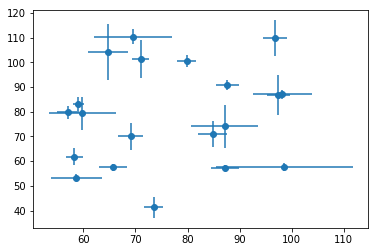

In [312]:
#plt.scatter(M31_all['width']/M31_all['width_random'], MW_all['width']/MW_all['width_random'])
plt.errorbar(M31_all['width'], MW_all['width'],
             xerr=M31_all['width_sigma'], yerr=MW_all['width_sigma'], fmt='o')
#x = np.linspace(0.6,1.3,20)
#plt.plot(x,x)

4.30745101812


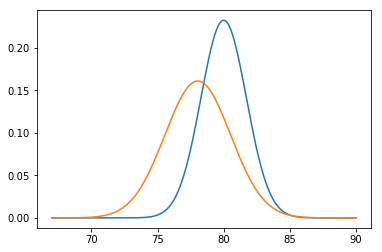

In [416]:
field = 'width_random'
def p(x,mean,sigma):
    return -0.5*((x-mean)/sigma)**2.0

n_alpha = 1000
alpha = np.linspace(67, 90.0, n_alpha)
p_alpha_data_M31 = np.zeros(n_alpha)
p_alpha_data_MW = np.zeros(n_alpha)
n_points =  len(M31_all[field])
for i in range(n_alpha):
    for j in range(n_points):
        p_alpha_data_M31[i] += p(M31_all[field][j], alpha[i], M31_all[field].std())
        p_alpha_data_MW[i] += p(MW_all[field][j], alpha[i], MW_all[field].std())
p_alpha_data_M31 = np.exp(p_alpha_data_M31 - p_alpha_data_M31.max())
p_alpha_data_MW = np.exp(p_alpha_data_MW - p_alpha_data_MW.max())
norm_M31 = np.trapz(p_alpha_data_M31, x=alpha)
norm_MW = np.trapz(p_alpha_data_MW, x=alpha)
print(norm_M31)
plt.plot(alpha, p_alpha_data_M31/norm_M31)
plt.plot(alpha, p_alpha_data_MW/norm_MW)

<Container object of 3 artists>

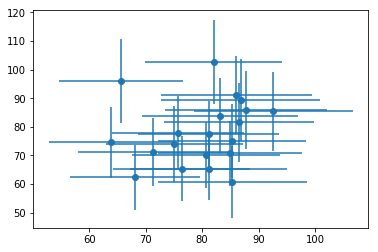

In [211]:
#plt.scatter(M31_all['width']/M31_all['width_random'], MW_all['width']/MW_all['width_random'])
plt.errorbar(M31_all['width_random'], MW_all['width_random'],
             xerr=M31_all['width_random_sigma'], yerr=MW_all['width_random_sigma'], fmt='o')
#x = np.linspace(0.6,1.3,20)
#plt.plot(x,x)

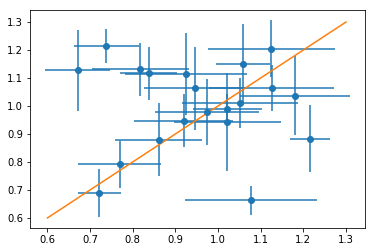

In [219]:
ratio_M31 = M31_all['width']/M31_all['width_random']
ratio_MW = MW_all['width']/MW_all['width_random']

xerr =  (M31_all['width_sigma']/M31_all['width'])**2 
xerr += (M31_all['width_random_sigma']/M31_all['width_random'])**2 
xerr += -2.0*(M31_all['width_sigma']/M31_all['width'])* (M31_all['width_random_sigma']/M31_all['width_random'])   
xerr = ratio_M31 * np.sqrt(xerr)
yerr =  (MW_all['width_sigma']/MW_all['width'])**2 
yerr += (MW_all['width_random_sigma']/MW_all['width_random'])**2 
yerr += -2.0*(MW_all['width_sigma']/MW_all['width'])* (MW_all['width_random_sigma']/MW_all['width_random'])   
yerr = ratio_MW * np.sqrt(yerr)
#plt.scatter(M31_all['width']/M31_all['width_random'], MW_all['width']/MW_all['width_random'])
plt.errorbar(ratio_M31, ratio_MW,
             xerr=xerr, yerr=yerr, fmt='o')
x = np.linspace(0.6,1.3,20)
plt.plot(x,x)

0.171302640654


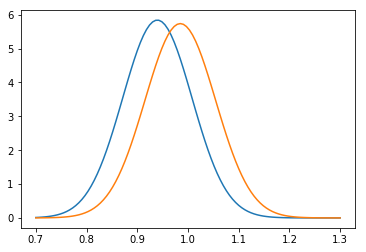

In [356]:
def p(x,mean,sigma):
    return -(x-mean)**2.0/(2.0*sigma)

n_alpha = 100
alpha = np.linspace(0.7, 1.3, n_alpha)
p_alpha_data_M31 = np.zeros(n_alpha)
p_alpha_data_MW = np.zeros(n_alpha)
n_points =  len(M31_all[field])
for i in range(n_alpha):
    for j in range(n_points):
        p_alpha_data_M31[i] += p(ratio_M31[j], alpha[i], xerr[j])
        p_alpha_data_MW[i] += p(ratio_MW[j], alpha[i], yerr[j])
p_alpha_data_M31 = np.exp(p_alpha_data_M31 - p_alpha_data_M31.max())
p_alpha_data_MW = np.exp(p_alpha_data_MW - p_alpha_data_MW.max())
norm_M31 = np.trapz(p_alpha_data_M31, x=alpha)
norm_MW = np.trapz(p_alpha_data_MW, x=alpha)
print(norm_M31)
plt.plot(alpha, p_alpha_data_M31/norm_M31)
plt.plot(alpha, p_alpha_data_MW/norm_MW)

Ks_2sampResult(statistic=0.45000000000000007, pvalue=0.023213275854449551)
KstestResult(statistic=0.23448000000000008, pvalue=0.18886578081990102)
KstestResult(statistic=0.25567999999999991, pvalue=0.12196960306520221)
Ks_2sampResult(statistic=0.42368421052631577, pvalue=0.042359302258534806)


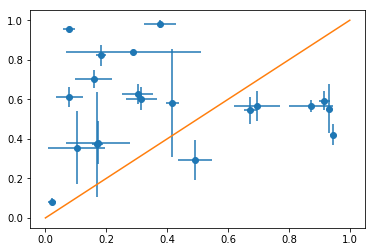

In [255]:
plt.errorbar(M31_all['mu'], MW_all['mu'],xerr=M31_all['mu_sigma'], yerr=MW_all['mu_sigma'], fmt='o')
print(stats.ks_2samp(M31_all['mu'], MW_all['mu']))
print(stats.kstest(M31_all['mu'], 'uniform'))
print(stats.kstest(MW_all['mu'], 'uniform'))
x = np.linspace(0.,1.,20)
plt.plot(x,x)
r = powerlaw.rvs(1.0, size=19)
print(stats.ks_2samp(MW_all['mu'], r))

0.843627937319


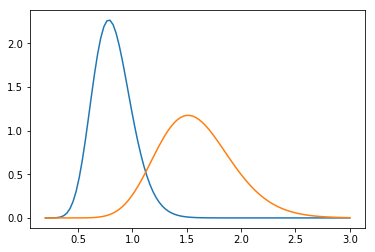

In [293]:
field = 'mu'
def p(x,alpha):
    return alpha * x**(alpha-1.0)
n_alpha = 100
alpha = np.linspace(0.2, 3.0, n_alpha)
p_alpha_data_M31 = np.ones(n_alpha)
p_alpha_data_MW = np.ones(n_alpha)
n_points =  len(M31_all[field])
for i in range(n_alpha):
    for j in range(n_points):
        p_alpha_data_M31[i] *= p(M31_all[field][j], alpha[i])
        p_alpha_data_MW[i] *= p(MW_all[field][j], alpha[i])
norm_M31 = np.trapz(p_alpha_data_M31, x=alpha)
norm_MW = np.trapz(p_alpha_data_MW, x=alpha)
print(norm_M31)
plt.plot(alpha, p_alpha_data_M31/norm_M31)
plt.plot(alpha, p_alpha_data_MW/norm_MW)

Ks_2sampResult(statistic=0.35000000000000003, pvalue=0.13494714803612687)
KstestResult(statistic=0.82499999999999996, pvalue=1.7763568394002505e-15)
KstestResult(statistic=0.80380000000000007, pvalue=1.8873791418627661e-14)


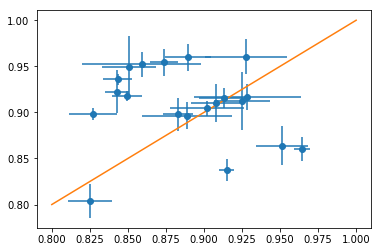

In [415]:
field = 'ba_ratio'
plt.errorbar(M31_all['ba_ratio'], MW_all['ba_ratio'],
             xerr=M31_all['ba_ratio_sigma'], yerr=MW_all['ba_ratio_sigma'], fmt='o')
print(stats.ks_2samp(M31_all[field], MW_all[field]))
print(stats.kstest(M31_all[field], 'uniform'))
print(stats.kstest(MW_all[field], 'uniform'))
x = np.linspace(0.8,1.,20)
plt.plot(x,x)

0.0224654188601


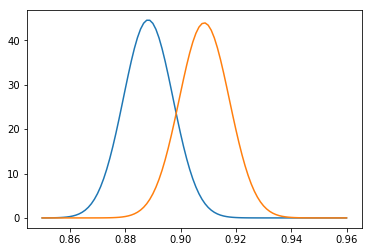

In [413]:
field = 'ba_ratio'
def p(x,mean,sigma):
    return (-0.5*((x-mean)/sigma)**2.0)

n_alpha = 100
alpha = np.linspace(0.85, 0.96, n_alpha)
p_alpha_data_M31 = np.zeros(n_alpha)
p_alpha_data_MW = np.zeros(n_alpha)
n_points =  len(M31_all[field])
for i in range(n_alpha):
    for j in range(n_points):
        p_alpha_data_M31[i] += p(M31_all[field][j], alpha[i], M31_all[field].std())
        p_alpha_data_MW[i] += p(MW_all[field][j], alpha[i], MW_all[field].std())
p_alpha_data_M31 = np.exp(p_alpha_data_M31 - p_alpha_data_M31.max())
p_alpha_data_MW = np.exp(p_alpha_data_MW - p_alpha_data_MW.max())
norm_M31 = np.trapz(p_alpha_data_M31, x=alpha)
norm_MW = np.trapz(p_alpha_data_MW, x=alpha)
print(norm_M31)
plt.plot(alpha, p_alpha_data_M31/norm_M31)
plt.plot(alpha, p_alpha_data_MW/norm_MW)
#a = plt.hist(M31_all[field], normed=True)

Ks_2sampResult(statistic=0.20000000000000001, pvalue=0.77095294467658682)


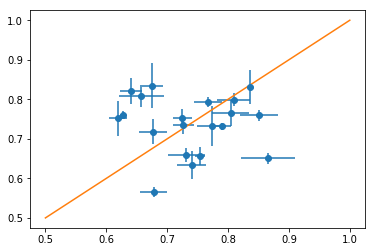

In [299]:
plt.errorbar(M31_all['ca_ratio'], MW_all['ca_ratio'],
             xerr=M31_all['ca_ratio_sigma'], yerr=MW_all['ca_ratio_sigma'], fmt='o')
print(stats.ks_2samp(M31_all['ca_ratio'], MW_all['ca_ratio']))
#print(stats.kstest(M31_all['mu'], 'uniform'))
#print(stats.kstest(MW_all['mu'], 'uniform'))
x = np.linspace(0.5,1.,20)
plt.plot(x,x)

0.0409811158905


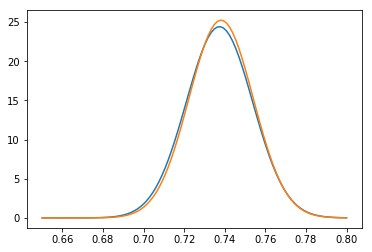

In [409]:
field = 'ca_ratio'
def p(x,mean,sigma):
    return (-0.5*((x-mean)/sigma)**2.0)

n_alpha = 100
alpha = np.linspace(0.65, 0.8, n_alpha)
p_alpha_data_M31 = np.zeros(n_alpha)
p_alpha_data_MW = np.zeros(n_alpha)
n_points =  len(M31_all[field])
for i in range(n_alpha):
    for j in range(n_points):
        p_alpha_data_M31[i] += p(M31_all[field][j], alpha[i], M31_all[field].std())
        p_alpha_data_MW[i] += p(MW_all[field][j], alpha[i], MW_all[field].std())
p_alpha_data_M31 = np.exp(p_alpha_data_M31 - p_alpha_data_M31.max())
p_alpha_data_MW = np.exp(p_alpha_data_MW - p_alpha_data_MW.max())
norm_M31 = np.trapz(p_alpha_data_M31, x=alpha)
norm_MW = np.trapz(p_alpha_data_MW, x=alpha)
print(norm_M31)
plt.plot(alpha, p_alpha_data_M31/norm_M31)
plt.plot(alpha, p_alpha_data_MW/norm_MW)
#a = plt.hist(M31_all[field], normed=True)